# Bibliotecas


In [ ]:
!pip install fancyimpute

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 3.8 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29880 sha256=68e9421d41b073bc442492002f23fa2af77f4acce6a43f96df6604718d0593cd
  Stored in directory: /root/.cache/pip/wheels/7b/0c/d3/ee82d1fbdcc0858d96434af108608d01703505d453720c84ed
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11330 sha256=d3402ff5b7869f50a53638702d0e42471d1da05c2fbc8526982b5483603812dc
  Stored in directory: /root/.cache/pip/wheels/46/06/a5/45a724630562413c374e29c08732411d496092408b3a7bf754
Successfully built fancyimpute knnimpute


In [ ]:
from fancyimpute import KNN
from sklearn.impute import KNNImputer
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# Leitura dos dados

Carregamos nosso dataset e exibimos as primeiras linhas para ter uma visão inicial dos dados.

In [ ]:
df = pd.read_csv('/content/train.csv')
#df = pd.read_csv("/content/drive/MyDrive/Disciplinas/Sistemas Inteligentes/train.csv", delimiter=';')

In [ ]:
df.head(90)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [ ]:
df["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [ ]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


Observamos que algumas features estão como "object", podemos mudá-las para "category", para que sejam armazenadas de mais eficiente, além de facilitar também operações sobre elas. Além disso, a primeira letra da cabine refere-se ao pavimento da cabine do hóspede. Por isso, removemos os números da coluna em questão para conseguir utilizar o dado de uma forma mais apropriada.

In [ ]:
df["Cabin"] = df["Cabin"].str[0]

df["Sex"] = df["Sex"].astype("category")
df["Cabin"] = df["Cabin"].astype("category")
df["Embarked"] = df["Embarked"].astype("category")


In [ ]:
df["Cabin"].unique()

[NaN, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T']
Categories (8, object): ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']

In [ ]:
df.dtypes

PassengerId       int64
Survived          int64
Pclass            int64
Name             object
Sex            category
Age             float64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Cabin          category
Embarked       category
dtype: object

# Verificar a existencia de dados duplicados

In [ ]:
len(df[df.duplicated()])


0

In [ ]:
df.drop_duplicates(keep='first', inplace=True)
len(df[df.duplicated()])


0

#Relevância da variável cabine

Considerando que a variável "Cabine" possui muitos valores nulos, irá ser realizada uma análise que terá como objetivo avaliar se essa variável possa gerar algum impacto relevante no classificador final ou se desconsiderá-la possa ser viável.

In [ ]:
mat = []

size = df[(df["Cabin"].isnull()) & (df["Survived"] == 1)].shape[0]
sizetotal = df[df["Cabin"].isnull()].shape[0]
mat.append([size, round(size*100/sizetotal, 2), sizetotal])

size = df[(df["Cabin"].notnull()) & (df["Survived"] == 1)].shape[0]
sizetotal = df[df["Cabin"].notnull()].shape[0]
mat.append([size, round(size*100/sizetotal, 2), sizetotal])

([<matplotlib.axis.YTick at 0x7c35dc2cd8d0>,
 [Text(0, 0, 'Cabin - NaN'), Text(0, 1, 'Cabin - Not Null')])

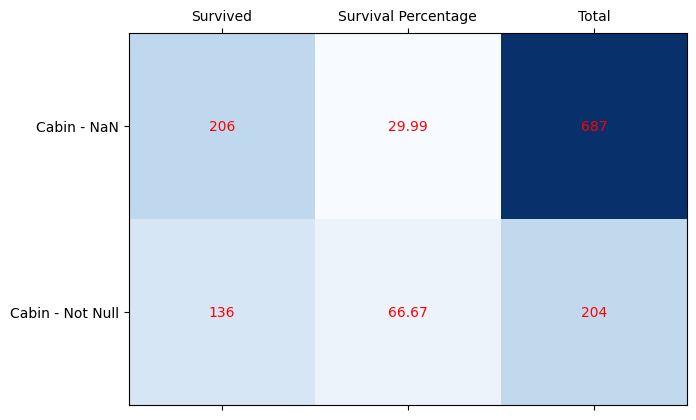

In [ ]:
Xaxis=["Survived", "Survival Percentage", "Total"]
Yaxis=["Cabin - NaN", "Cabin - Not Null"]
plt.matshow(mat, cmap=plt.cm.Blues)
for i in range(len(mat)):
    for j in range(len(mat[i])):
        c = mat[i][j]
        plt.text(j, i, str(c), va='center', ha='center', color = '#FF0000')

plt.xticks(np.arange(0,len(Xaxis), step = 1), labels = [Xaxis[i] for i in range(len(Xaxis))])
plt.yticks(np.arange(0,len(Yaxis), step = 1), labels = [Yaxis[i] for i in range(len(Yaxis))])

Observando as ocorências dessa variável, podemos observar que talvez ela possa ser importante para o classificador, pois passageiros com registro nulo de cabine possuem baixa chance de sobrevivência e passageiros com registro possui uma chance de sobrevivência mais elevada. Logo, pode-se concluir que incluir essa variável em pelo menos uma ocorrência de classificador talvez possa ser capaz de gerar resultados positivos.

# Tratamento de valores ausentes

Para os dados numéricos, utilizaremos a interpolação  para prever os valores ausentes com base nos valores vizinhos. Para os dados categórigos, optamos por colocar o atributo em questão como "desconhecido".

In [ ]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
predict_df = df.copy(deep=True)
predict_df['Age'].interpolate(method='linear', inplace=True)

In [ ]:
predict_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
predict_df['DadosNulos'] = df['Cabin'].isnull().astype(int)
predict_df['Cabin'] = predict_df['Cabin'].cat.add_categories(['Desconhecido'])
predict_df['Embarked'] = predict_df['Embarked'].cat.add_categories(['Desconhecido'])

predict_df['Cabin'].fillna('Desconhecido', inplace=True)
predict_df['Embarked'].fillna('Desconhecido', inplace=True)
predict_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,DadosNulos
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Desconhecido,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Desconhecido,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Desconhecido,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,Desconhecido,S,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B,S,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,22.5,1,2,W./C. 6607,23.4500,Desconhecido,S,1
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,C,0


In [ ]:
predict_df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
DadosNulos     0
dtype: int64

# Graficos

Para analisar o comportamento dos dados, e possivelmente indentificar as categorias que podem estar mais ou menos relacionadas ao resultado final (identificar os passageiros que sobreviveram ou não ao acidente do Titanic), a plotagem de algumas distribuições e a subsequente visualização de padrões presentes nos dados será realizada. O começo dessa análise irá partir com base na porcentagem total de sobreviventes:     

In [ ]:
predict_df['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

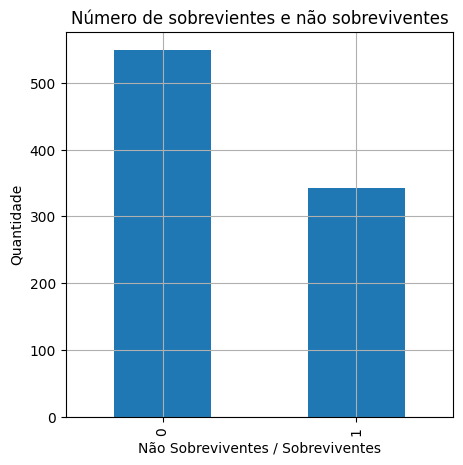

In [ ]:
plt.figure();

pltdf = predict_df['Survived'].value_counts()

pltdf.plot.bar(y = [pltdf[0], pltdf[1]], figsize=(5, 5), grid = True)

plt.title('Número de sobrevientes e não sobreviventes')
plt.xlabel('Não Sobreviventes / Sobreviventes')
plt.ylabel('Quantidade')
plt.show()

In [ ]:
percentage = pltdf[1] * 100 / (pltdf[0]+pltdf[1])
print("Porcentagem de sobreviventes:")
print(str(percentage) + "%")

Porcentagem de sobreviventes:
38.38383838383838%


Logo, temos que, a porcentagem de uma pessoa qualquer ter sobrevivido ao acidente, sem considerar questões como idade ou classe, é de aproximadamente 39%. Para observar como os dados que temos acesso podem nos ajudar a inferir a chance da sobrevivência de uma pessoa, uma análise acerca da distribuição de idade de sobreviventes e não sobreviventes será realizada a seguir:

In [ ]:
def string_labels (survivor_labels):
  string_labels = []
  for label in survivor_labels:
    if(label == 0): string_labels.append("Não Sobreviventes")
    else: string_labels.append("Sobreviventes")
  return string_labels

array([<Axes: title={'center': 'Não Sobreviventes'}, ylabel='Frequency'>,
       <Axes: title={'center': 'Sobreviventes'}, ylabel='Frequency'>],
      dtype=object)

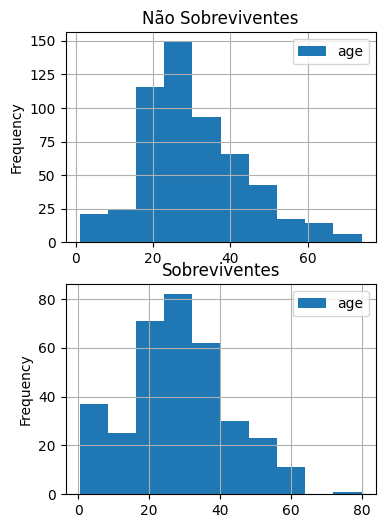

In [ ]:
pltdf = predict_df.copy()

tmp_df = pd.DataFrame({"Survived": string_labels(pltdf["Survived"]), "age": pltdf["Age"]})

tmp_df.plot.hist(column=["age"], by="Survived", figsize=(4, 6), grid = True)

Analisando o histograma, podemos perceber uma porcentagem relativa maior de sobreviventes menores de idade e uma porcentagem bem menor em sujeitos acima dos 60 anos de idade. Continuando a análise da chance de sobrevivência baseada na idade:

In [ ]:
tmp_df["age"].max()

80.0

In [ ]:
mat = []
age_gaps = [-1, 10, 20, 30, 40, 50, 60, 70, 80]
for i in range (len(age_gaps)-1):
  size = pltdf[(pltdf["Age"] > age_gaps[i]) & (pltdf["Age"] <= age_gaps[i+1]) & (pltdf["Survived"] == 1)].shape[0]
  sizetotal = pltdf[(pltdf["Age"] > age_gaps[i]) & (pltdf["Age"] <= age_gaps[i+1])].shape[0]
  mat.append([size, round(size*100/sizetotal, 2), sizetotal])

([<matplotlib.axis.YTick at 0x7c35dbf8ce50>,
 [Text(0, 0, '0-10'),
  Text(0, 1, '11-20'),
  Text(0, 2, '21-30'),
  Text(0, 3, '31-40'),
  Text(0, 4, '41-50'),
  Text(0, 5, '51-60'),
  Text(0, 6, '61-70'),
  Text(0, 7, '71-80')])

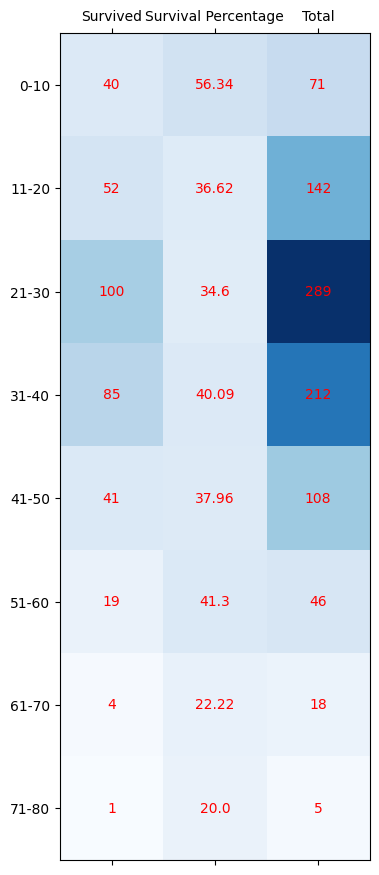

In [ ]:
Xaxis=["Survived", "Survival Percentage", "Total"]
Yaxis=["0-10", "11-20", "21-30", "31-40", "41-50", "51-60", "61-70", "71-80"]
plt.matshow(mat, cmap=plt.cm.Blues)
for i in range(len(mat)):
    for j in range(len(mat[i])):
        c = mat[i][j]
        plt.text(j, i, str(c), va='center', ha='center', color = '#FF0000')

plt.xticks(np.arange(0,len(Xaxis), step = 1), labels = [Xaxis[i] for i in range(len(Xaxis))])
plt.yticks(np.arange(0,len(Yaxis), step = 1), labels = [Yaxis[i] for i in range(len(Yaxis))])

Com isso, é possível confirmar as suspeitas anteriores, já que realmente pode ser observado um maior índice de sobrevivência para pessoas abaixo de 10 anos, uma menor para sujeitos acima de 60, e uma taxa sem variações muito bruscas para as outras idades. Extendendo essa análise para sexo e classe:

In [ ]:
mat = []
size = pltdf[(pltdf["Sex"] == "male") & (pltdf["Survived"] == 1)].shape[0]
sizetotal = pltdf[(pltdf["Sex"] == "male")].shape[0]
mat.append([size, round(size*100/sizetotal, 2), sizetotal])
size = pltdf[(pltdf["Sex"] == "female") & (pltdf["Survived"] == 1)].shape[0]
sizetotal = pltdf[(pltdf["Sex"] == "female")].shape[0]
mat.append([size, round(size*100/sizetotal, 2), sizetotal])

([<matplotlib.axis.YTick at 0x7c35dc1a4250>,
 [Text(0, 0, 'Male'), Text(0, 1, 'Female')])

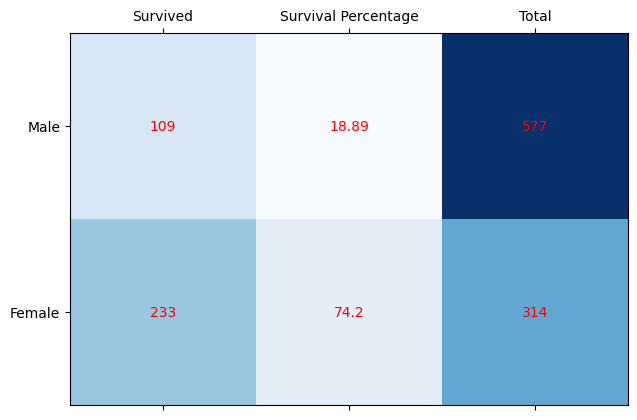

In [ ]:
Xaxis=["Survived", "Survival Percentage", "Total"]
Yaxis=["Male", "Female"]
plt.matshow(mat, cmap=plt.cm.Blues)
for i in range(len(mat)):
    for j in range(len(mat[i])):
        c = mat[i][j]
        plt.text(j, i, str(c), va='center', ha='center', color = '#FF0000')

plt.xticks(np.arange(0,len(Xaxis), step = 1), labels = [Xaxis[i] for i in range(len(Xaxis))])
plt.yticks(np.arange(0,len(Yaxis), step = 1), labels = [Yaxis[i] for i in range(len(Yaxis))])

In [ ]:
mat = []
pclasses = [1, 2, 3]
for pclass in pclasses :
  size = pltdf[(pltdf["Pclass"] == pclass) & (pltdf["Survived"] == 1)].shape[0]
  sizetotal = pltdf[(pltdf["Pclass"] == pclass)].shape[0]
  mat.append([size, round(size*100/sizetotal, 2), sizetotal])

([<matplotlib.axis.YTick at 0x7c35dbffeec0>,
 [Text(0, 0, 'Upper'), Text(0, 1, 'Middle'), Text(0, 2, 'Lower')])

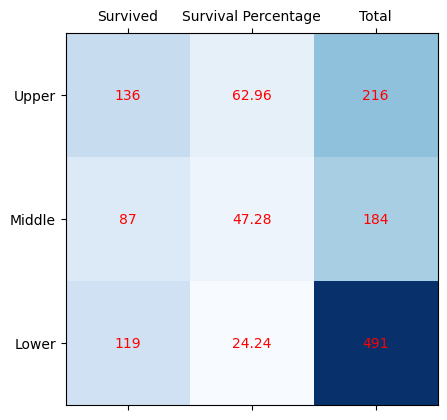

In [ ]:
Xaxis=["Survived", "Survival Percentage", "Total"]
Yaxis=["Upper", "Middle", "Lower"]
plt.matshow(mat, cmap=plt.cm.Blues)
for i in range(len(mat)):
    for j in range(len(mat[i])):
        c = mat[i][j]
        plt.text(j, i, str(c), va='center', ha='center', color = '#FF0000')

plt.xticks(np.arange(0,len(Xaxis), step = 1), labels = [Xaxis[i] for i in range(len(Xaxis))])
plt.yticks(np.arange(0,len(Yaxis), step = 1), labels = [Yaxis[i] for i in range(len(Yaxis))])

Logo, também podemos analisar uma certa influência da classe do ticket e do sexo que apontam para maiores chances de sobrevivência. Por último, também será realizada a análise do número de parentes à bordo, que intuitivamente parece ser menos sujestivo que os outros dados análisados até agora:

In [ ]:
pltdf["Parch"].max()

6

In [ ]:
mat = []
parchs = [0, 1, 2, 3, 4, 5, 6,]
for parch in parchs :
  size = pltdf[(pltdf["Parch"] == parch) & (pltdf["Survived"] == 1)].shape[0]
  sizetotal = pltdf[(pltdf["Parch"] == parch)].shape[0]
  if(sizetotal > 0): mat.append([size, round(size*100/sizetotal, 2), sizetotal])

([<matplotlib.axis.YTick at 0x7c35dbe80b80>,
 [Text(0, 0, '0'),
  Text(0, 1, '1'),
  Text(0, 2, '2'),
  Text(0, 3, '3'),
  Text(0, 4, '4'),
  Text(0, 5, '5'),
  Text(0, 6, '6')])

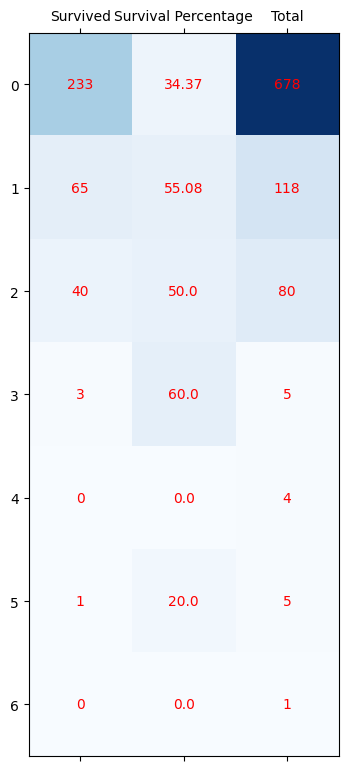

In [ ]:
Xaxis=["Survived", "Survival Percentage", "Total"]
Yaxis=[0, 1, 2, 3, 4, 5, 6]
plt.matshow(mat, cmap=plt.cm.Blues)
for i in range(len(mat)):
    for j in range(len(mat[i])):
        c = mat[i][j]
        plt.text(j, i, str(c), va='center', ha='center', color = '#FF0000')

plt.xticks(np.arange(0,len(Xaxis), step = 1), labels = [Xaxis[i] for i in range(len(Xaxis))])
plt.yticks(np.arange(0,len(Yaxis), step = 1), labels = [Yaxis[i] for i in range(len(Yaxis))])

Boa parte dos valores encontrados possuem amostras muito pequenas, o que pode reduzir a aplicabilidade desse dado, porém, ainda assim, pode-se observar uma chance consideravelmente maior de sobrevivência de pessoas com 1 ou 2 parentes ou crianças à bordo do que aqueles sem parentes, ou seja, esse dado ainda pode também ser considerado relevante de forma e ser utilizado como um dos parâmetros do modelo.

#Discretização

In [ ]:
bins = [0, 10, 50, 60, float('inf')]
labels = ['0-10', '11-50', '51-60', '60+']

predict_df['Age_disc'] = pd.cut(predict_df['Age'], bins=bins, labels=labels, right=False)

In [ ]:
predict_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,DadosNulos,Age_disc
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Desconhecido,S,1,11-50
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,0,11-50
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Desconhecido,S,1,11-50
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,0,11-50
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Desconhecido,S,1,11-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,Desconhecido,S,1,11-50
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B,S,0,11-50
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,22.5,1,2,W./C. 6607,23.4500,Desconhecido,S,1,11-50
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,C,0,11-50


# Normalização

A normalização é crucial para garantir que variáveis com escalas diferentes não distorçam os resultados analíticos, especialmente em técnicas de análise que são sensíveis a variações de escala, como modelagem preditiva e algoritmos de machine learning.

In [ ]:
predict_norm_df = predict_df.copy(deep=True)

In [ ]:
predict_norm_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,DadosNulos,Age_disc
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Desconhecido,S,1,11-50
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,0,11-50
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Desconhecido,S,1,11-50
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,0,11-50
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Desconhecido,S,1,11-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,Desconhecido,S,1,11-50
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B,S,0,11-50
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,22.5,1,2,W./C. 6607,23.4500,Desconhecido,S,1,11-50
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,C,0,11-50


In [ ]:
predict_norm_df['Sex'] = predict_norm_df['Sex'].astype('category').cat.codes
predict_norm_df['Cabin'] = predict_norm_df['Cabin'].astype('category').cat.codes
predict_norm_df['Age_disc'] = predict_norm_df['Age_disc'].astype('category').cat.codes

In [ ]:
predict_norm_df['Age'] = (predict_norm_df['Age'] - predict_norm_df['Age'].min()) / (predict_norm_df['Age'].max() - predict_norm_df['Age'].min())
predict_norm_df['Pclass'] = (predict_norm_df['Pclass'] - predict_norm_df['Pclass'].min()) / (predict_norm_df['Pclass'].max() - predict_norm_df['Pclass'].min())
predict_norm_df['SibSp'] = (predict_norm_df['SibSp'] - predict_norm_df['SibSp'].min()) / (predict_norm_df['SibSp'].max() - predict_norm_df['SibSp'].min())
predict_norm_df['Parch'] = (predict_norm_df['Parch'] - predict_norm_df['Parch'].min()) / (predict_norm_df['Parch'].max() - predict_norm_df['Parch'].min())
predict_norm_df['Fare'] = (predict_norm_df['Fare'] - predict_norm_df['Fare'].min()) / (predict_norm_df['Fare'].max() - predict_norm_df['Fare'].min())
predict_norm_df['Cabin'] = (predict_norm_df['Cabin'] - predict_norm_df['Cabin'].min()) / (predict_norm_df['Cabin'].max() - predict_norm_df['Cabin'].min())
predict_norm_df['Age_disc'] = (predict_norm_df['Age_disc'] - predict_norm_df['Age_disc'].min()) / (predict_norm_df['Age_disc'].max() - predict_norm_df['Age_disc'].min())


In [ ]:
predict_norm_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,DadosNulos,Age_disc
0,1,0,1.0,"Braund, Mr. Owen Harris",1,0.271174,0.125,0.000000,A/5 21171,0.014151,1.00,S,1,0.333333
1,2,1,0.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,0.472229,0.125,0.000000,PC 17599,0.139136,0.25,C,0,0.333333
2,3,1,1.0,"Heikkinen, Miss. Laina",0,0.321438,0.000,0.000000,STON/O2. 3101282,0.015469,1.00,S,1,0.333333
3,4,1,0.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,0.434531,0.125,0.000000,113803,0.103644,0.25,S,0,0.333333
4,5,0,1.0,"Allen, Mr. William Henry",1,0.434531,0.000,0.000000,373450,0.015713,1.00,S,1,0.333333
5,6,0,1.0,"Moran, Mr. James",1,0.553908,0.000,0.000000,330877,0.016510,1.00,Q,1,0.333333
6,7,0,0.0,"McCarthy, Mr. Timothy J",1,0.673285,0.000,0.000000,17463,0.101229,0.50,S,0,0.666667
7,8,0,1.0,"Palsson, Master. Gosta Leonard",1,0.019854,0.375,0.166667,349909,0.041136,1.00,S,1,0.000000
8,9,1,1.0,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,0.334004,0.000,0.333333,347742,0.021731,1.00,S,1,0.333333
9,10,1,0.5,"Nasser, Mrs. Nicholas (Adele Achem)",0,0.170646,0.125,0.000000,237736,0.058694,1.00,C,1,0.333333


Normalizar os dados é importante porque algoritmos como K-Means clustering, PCA, regressão linear e redes neurais podem ser influenciados negativamente por variáveis que têm escalas muito diferentes. Isso pode levar a resultados distorcidos ou subótimos. Além de melhorar a precisão dos modelos, a normalização facilita a visualização dos dados, ajudando a identificar padrões e outliers de forma mais clara e precisa.

#Divisão do dataset e balanceamento das classes

In [ ]:
def div_test_train(df):
  X = df.drop('Survived', axis=1)
  y = df['Survived']

  # Dividir o dataset em treinamento e teste
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  # Aplicar SMOTE ao conjunto de treinamento
  smote = SMOTE(random_state=42)
  X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

  return X_train_res, X_test, y_train_res, y_test

In [ ]:
df_div = predict_norm_df.copy(deep=True)
df_div.drop(["Name", "PassengerId", "Ticket", "Embarked", "Age"], axis=1, inplace=True)


#Arvore de decisão

Árvores de decisão são um modelo de aprendizado de máquina que toma decisões com base em uma série de perguntas simples, organizadas em forma de árvore. Cada "nó" da árvore representa uma decisão sobre uma característica dos dados, e cada "ramo" representa o resultado dessa decisão, direcionando para o próximo nó ou para uma decisão final.

O processo começa com o nó raiz, onde a primeira decisão é feita. A árvore é dividida em ramos com base nos valores das características, e cada ramificação leva a novos nós onde outras decisões são feitas. Esse processo continua até que as folhas da árvore sejam alcançadas, que representam a decisão final ou a previsão.

## Teste 1

In [ ]:
df_teste1 = df_div.copy(deep=True)
X_train, X_test, y_train, y_test = div_test_train(df_teste1)

Acurácia: 0.7873134328358209

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82       157
           1       0.75      0.74      0.74       111

    accuracy                           0.79       268
   macro avg       0.78      0.78      0.78       268
weighted avg       0.79      0.79      0.79       268


Matriz de Confusão:
 [[129  28]
 [ 29  82]]


[Text(0.37783022280092593, 0.9722222222222222, 'Sex <= 0.5\ngini = 0.5\nsamples = 784\nvalue = [392, 392]\nclass = Not Survived'),
 Text(0.15046296296296297, 0.9166666666666666, 'Pclass <= 0.75\ngini = 0.289\nsamples = 331\nvalue = [58, 273]\nclass = Survived'),
 Text(0.06481481481481481, 0.8611111111111112, 'Fare <= 0.296\ngini = 0.041\nsamples = 191\nvalue = [4, 187]\nclass = Survived'),
 Text(0.046296296296296294, 0.8055555555555556, 'Fare <= 0.056\ngini = 0.023\nsamples = 170\nvalue = [2, 168]\nclass = Survived'),
 Text(0.037037037037037035, 0.75, 'Fare <= 0.055\ngini = 0.054\nsamples = 72\nvalue = [2, 70]\nclass = Survived'),
 Text(0.027777777777777776, 0.6944444444444444, 'SibSp <= 0.095\ngini = 0.028\nsamples = 71\nvalue = [1, 70]\nclass = Survived'),
 Text(0.018518518518518517, 0.6388888888888888, 'gini = 0.0\nsamples = 48\nvalue = [0, 48]\nclass = Survived'),
 Text(0.037037037037037035, 0.6388888888888888, 'Fare <= 0.043\ngini = 0.083\nsamples = 23\nvalue = [1, 22]\nclass = Su

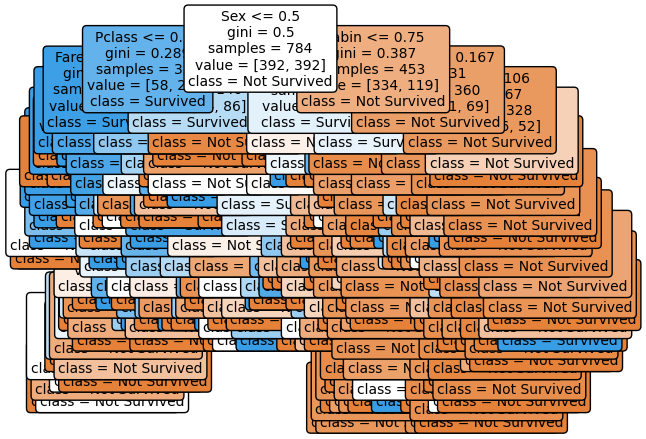

In [ ]:
clf = DecisionTreeClassifier(random_state=42)

# Treinar o modelo
clf.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = clf.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Acurácia:", accuracy)
print("\nRelatório de Classificação:\n", class_report)
print("\nMatriz de Confusão:\n", conf_matrix)

plot_tree(
    clf,
    filled=True,
    feature_names=X_train.columns,
    class_names=['Not Survived', 'Survived'],
    rounded=True,
    proportion=False,
    fontsize=10
)


Importância das Features:
Fare: 0.3611
Sex: 0.3477
Pclass: 0.0696
Cabin: 0.0678
SibSp: 0.0591
Age_disc: 0.0555
Parch: 0.0393
DadosNulos: 0.0000


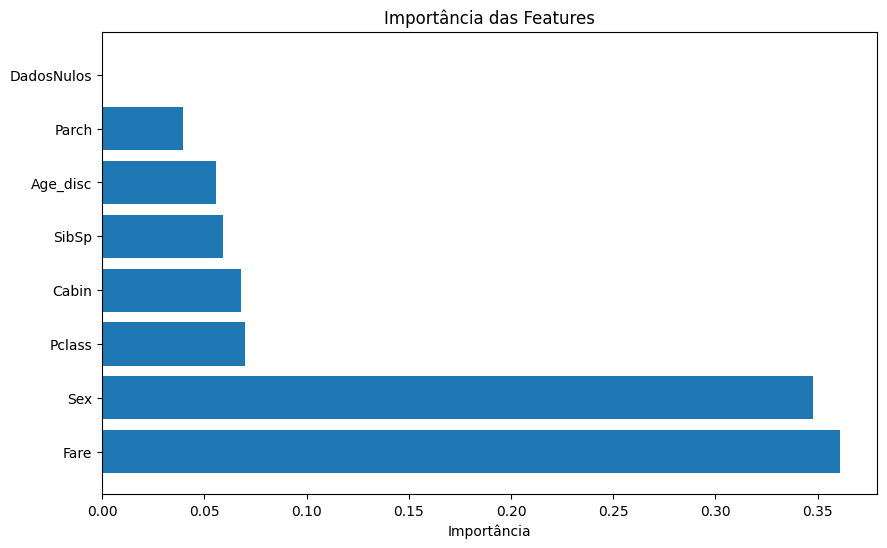

In [ ]:
importances = clf.feature_importances_
indices = importances.argsort()[::-1]  # Ordena as importâncias em ordem decrescente

# Exibir a importância das features
print("\nImportância das Features:")
for i in indices:
    print(f"{X_train.columns[i]}: {importances[i]:.4f}")

# Visualizar a importância das features em um gráfico
plt.figure(figsize=(10,6))
plt.title("Importância das Features")
plt.barh(range(X_train.shape[1]), importances[indices], align='center')
plt.yticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices])
plt.xlabel("Importância")
plt.show()

##Teste 2

In [ ]:
df_teste2 = df_div.copy(deep=True)
df_teste2.drop(["Cabin", "Parch", "SibSp", "DadosNulos"], axis=1, inplace=True)
X_train, X_test, y_train, y_test = div_test_train(df_teste2)

Acurácia: 0.8432835820895522

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87       157
           1       0.81      0.81      0.81       111

    accuracy                           0.84       268
   macro avg       0.84      0.84      0.84       268
weighted avg       0.84      0.84      0.84       268


Matriz de Confusão:
 [[136  21]
 [ 21  90]]


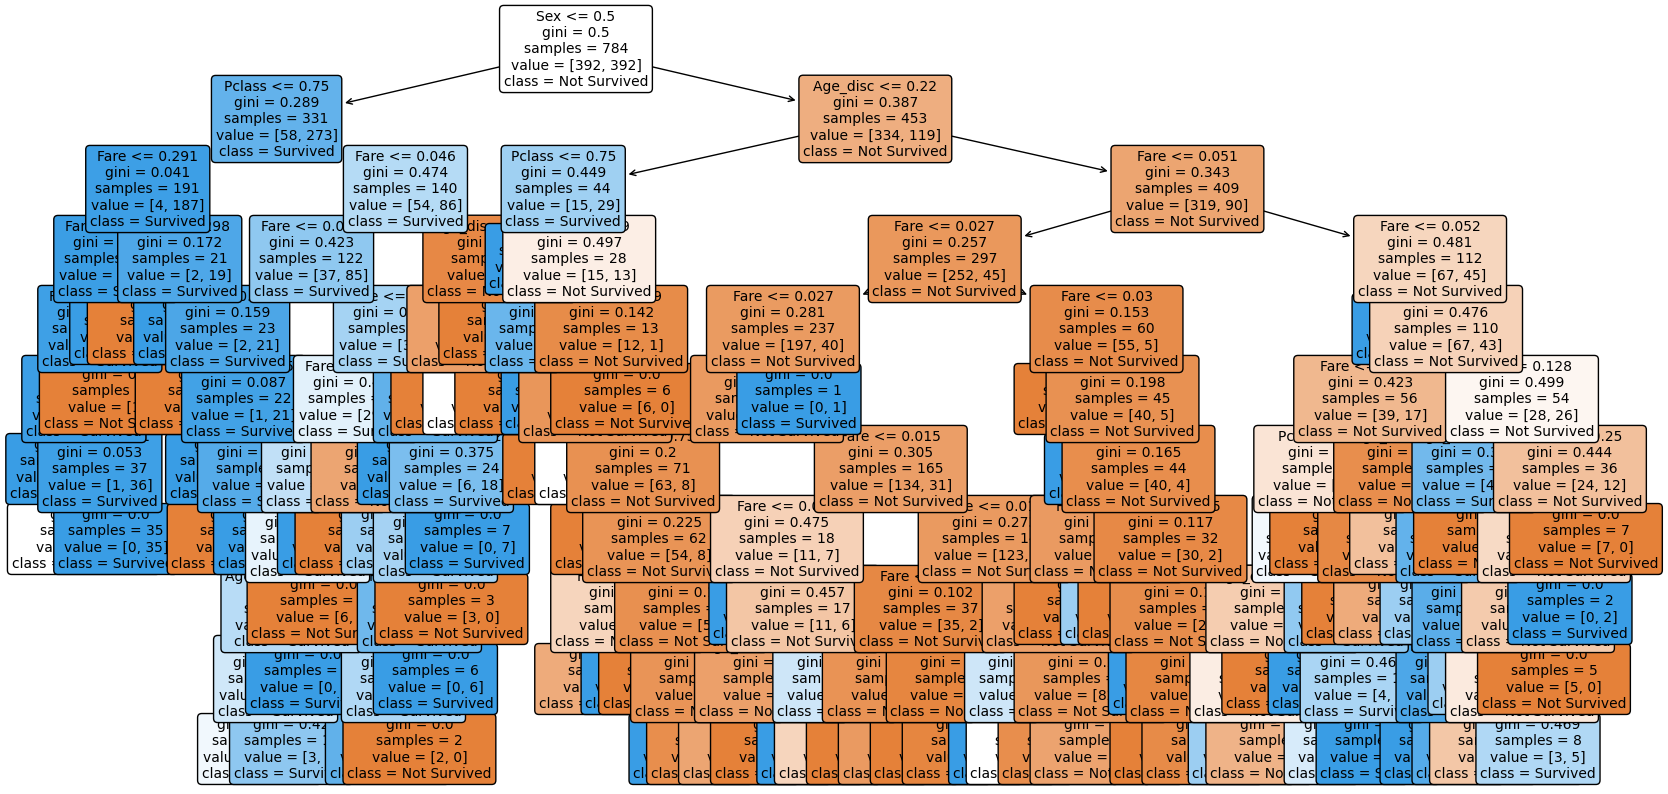

In [ ]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_split=5, random_state=42)

# Treinar o modelo
clf.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = clf.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Acurácia:", accuracy)
print("\nRelatório de Classificação:\n", class_report)
print("\nMatriz de Confusão:\n", conf_matrix)
plt.figure(figsize=(20,10))

plot_tree(
    clf,
    filled=True,
    feature_names=X_train.columns,
    class_names=['Not Survived', 'Survived'],
    rounded=True,
    proportion=False,
    fontsize=10
)
plt.show()


Importância das Features:
Sex: 0.4158
Fare: 0.4051
Pclass: 0.1111
Age_disc: 0.0680


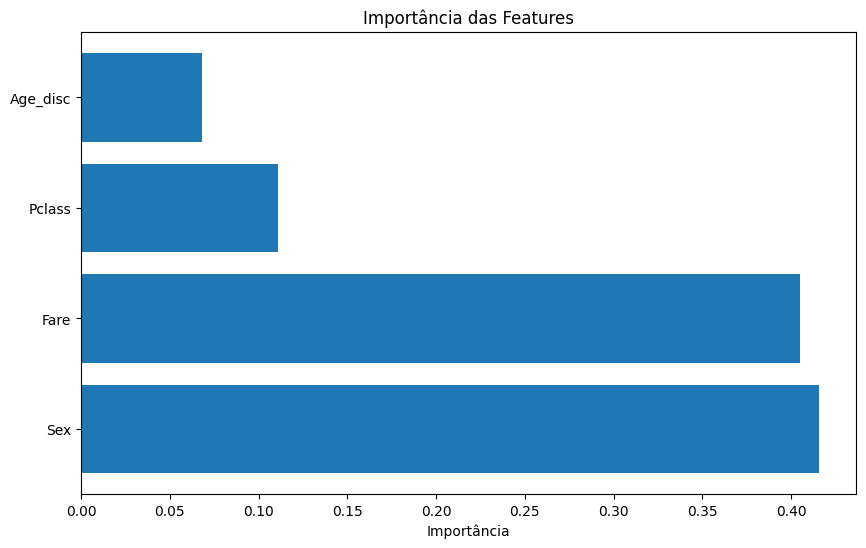

In [ ]:
importances = clf.feature_importances_
indices = importances.argsort()[::-1]  # Ordena as importâncias em ordem decrescente

# Exibir a importância das features
print("\nImportância das Features:")
for i in indices:
    print(f"{X_train.columns[i]}: {importances[i]:.4f}")

# Visualizar a importância das features em um gráfico
plt.figure(figsize=(10,6))
plt.title("Importância das Features")
plt.barh(range(X_train.shape[1]), importances[indices], align='center')
plt.yticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices])
plt.xlabel("Importância")
plt.show()

##Teste 3

In [ ]:
df_teste3 = df_div.copy(deep=True)
df_teste3.drop(["Cabin", "Parch", "SibSp", "Cabin", "DadosNulos"], axis=1, inplace=True)
X_train, X_test, y_train, y_test = div_test_train(df_teste3)

Melhores parâmetros: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Acurácia: 0.832089552238806

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86       157
           1       0.83      0.75      0.79       111

    accuracy                           0.83       268
   macro avg       0.83      0.82      0.82       268
weighted avg       0.83      0.83      0.83       268


Matriz de Confusão:
 [[140  17]
 [ 28  83]]


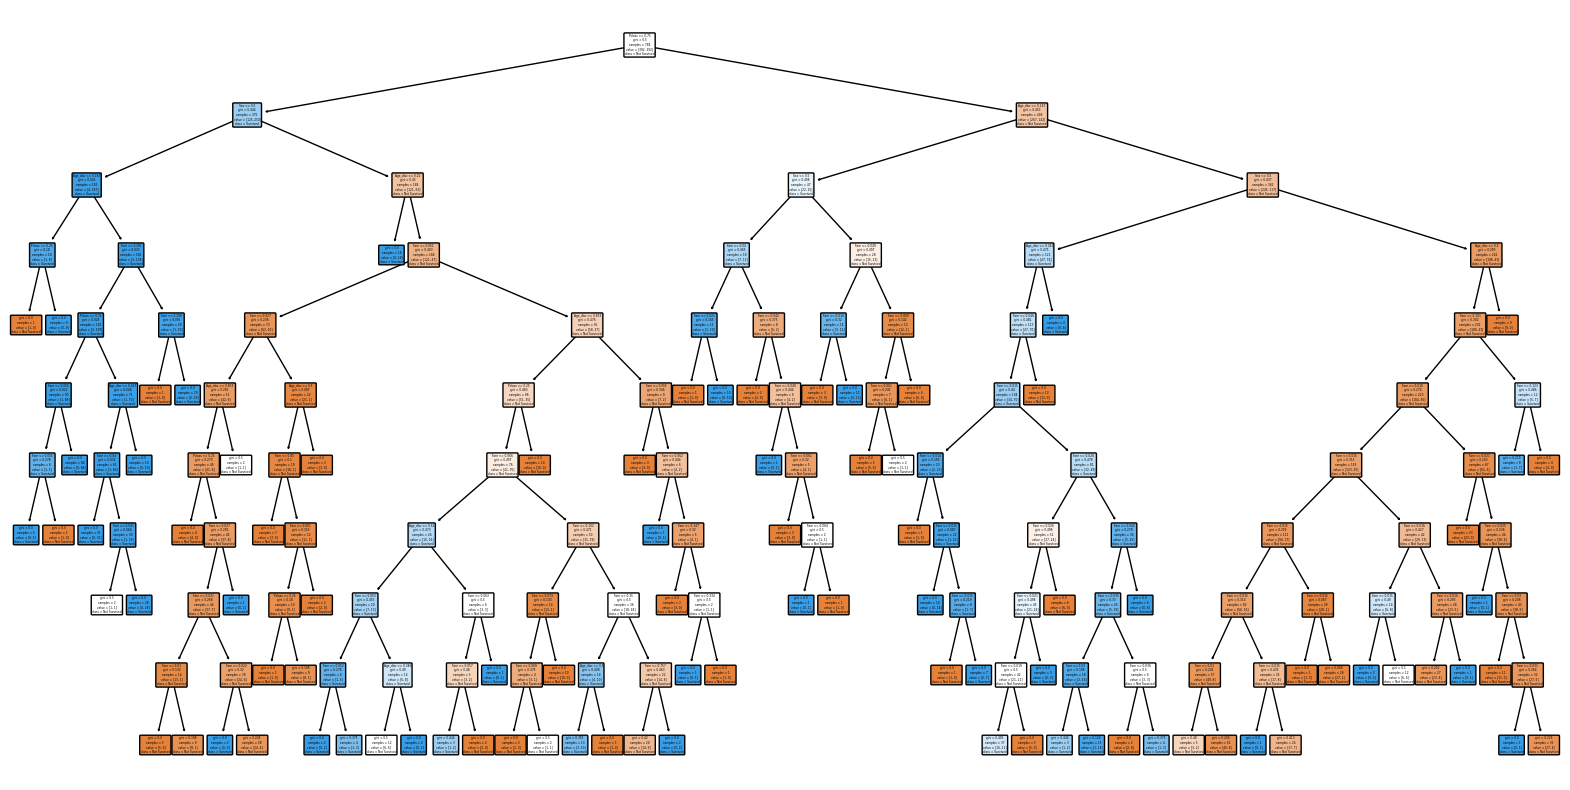

In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}

clf = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Melhores parâmetros:", best_params)

best_clf = grid_search.best_estimator_
best_clf.fit(X_train, y_train)

y_pred = best_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Acurácia:", accuracy)
print("\nRelatório de Classificação:\n", class_report)
print("\nMatriz de Confusão:\n", conf_matrix)

plt.figure(figsize=(20,10))
plot_tree(best_clf, feature_names=X_train.columns, class_names=['Not Survived', 'Survived'], filled=True, rounded=True)
plt.show()

Mesmo que a acurácia não tenha melhorado significativamente com o uso do GridSearchCV, o valor obtido é mais confiável porque leva em conta a validação cruzada. A validação cruzada envolve dividir o conjunto de dados em vários subconjuntos e treinar e testar o modelo em diferentes combinações desses subconjuntos. Isso significa que o modelo é avaliado em vários conjuntos de dados diferentes, o que proporciona uma estimativa mais robusta do seu desempenho real.

Portanto, mesmo que a acurácia final não tenha mudado muito, o fato de ter sido calculada usando validação cruzada indica que a avaliação é mais geral e menos dependente de uma única divisão dos dados. Em outras palavras, o modelo foi testado em várias configurações diferentes do conjunto de dados, o que ajuda a garantir que a acurácia medida é uma estimativa mais precisa e representativa do desempenho do modelo em dados novos e não vistos.

#Random Forest


O Random Forest é um modelo de aprendizado de máquina que utiliza um conjunto de árvores de decisão para melhorar a precisão das previsões e reduzir o risco de overfitting. Em vez de usar uma única árvore, o Random Forest constrói várias árvores de decisão, cada uma treinada em um subconjunto diferente dos dados. Esses subconjuntos são selecionados aleatoriamente com substituição, o que garante diversidade entre as árvores.

GridSearchCV é uma técnica essencial para otimizar modelos de machine learning, como o RandomForestClassifier. Seu principal objetivo é encontrar a melhor combinação de hiperparâmetros para o modelo, o que pode resultar em um desempenho significativamente melhor.

Os hiperparâmetros são configurações do modelo que não são aprendidas durante o treinamento, mas definidas antes. No caso do Random Forest, exemplos incluem o número de árvores (n_estimators), a profundidade máxima das árvores (max_depth), e o número mínimo de amostras por folha (min_samples_leaf). Ajustar esses parâmetros pode ser crucial, pois configurações inadequadas podem levar a problemas como overfitting ou underfitting.

In [ ]:
df_teste4 = df_div.copy(deep=True)
df_teste4.drop(["Cabin", "Parch", "SibSp", "Cabin", "DadosNulos"], axis=1, inplace=True)
X_train, X_test, y_train, y_test = div_test_train(df_teste4)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Melhores parâmetros: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Acurácia: 0.8432835820895522

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87       157
           1       0.83      0.77      0.80       111

    accuracy                           0.84       268
   macro avg       0.84      0.83      0.84       268
weighted avg       0.84      0.84      0.84       268


Matriz de Confusão:
 [[140  17]
 [ 25  86]]

Importância das Features:
Fare: 0.4023
Sex: 0.3982
Pclass: 0.1166
Age_disc: 0.0829


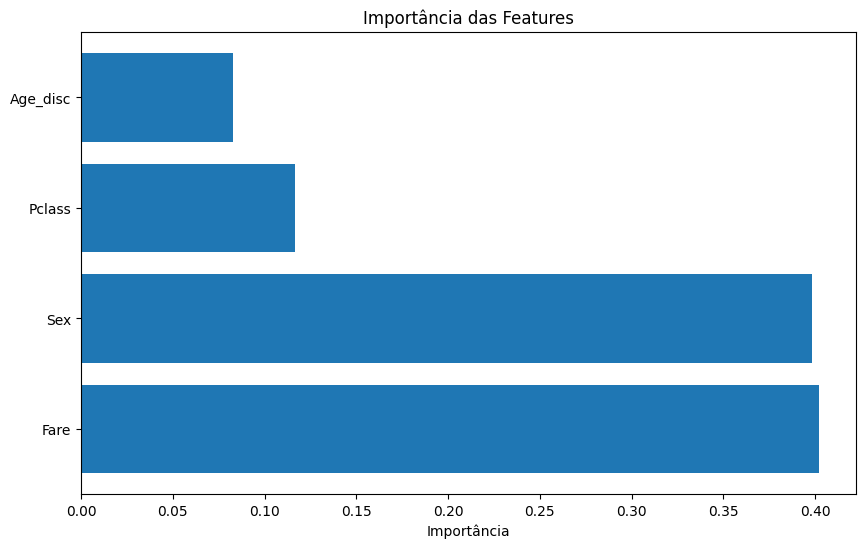

In [ ]:
rf = RandomForestClassifier(random_state=42)

# Definir a grade de parâmetros para a busca
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Inicializar o GridSearchCV com 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Ajustar o modelo
grid_search.fit(X_train, y_train)

# Melhor conjunto de parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros:", best_params)

best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = best_rf.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Acurácia:", accuracy)
print("\nRelatório de Classificação:\n", class_report)
print("\nMatriz de Confusão:\n", conf_matrix)

# Verificar as importâncias das features
importances = best_rf.feature_importances_
indices = importances.argsort()[::-1]  # Ordena as importâncias em ordem decrescente

# Exibir a importância das features
print("\nImportância das Features:")
for i in indices:
    print(f"{X_train.columns[i]}: {importances[i]:.4f}")

# Visualizar a importância das features em um gráfico
plt.figure(figsize=(10,6))
plt.title("Importância das Features")
plt.barh(range(X_train.shape[1]), importances[indices], align='center')
plt.yticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices])
plt.xlabel("Importância")
plt.show()